<a href="https://colab.research.google.com/github/Zypher44/Hello-world/blob/master/TransferLearingFeatureExtraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Transfer learning with TensorFlow two benefits 

There are two main beenfits 
1. Can leverage an existing neural netowrk architercutre proven to work on problems similar to our own 
2. Can leverage a working neural netowrk architecuter which has already learned patterns on similar data to our own, 
then we can adapt those patterns to our own data 

In [6]:
!nvidia-smi

Fri Jul  2 20:39:18 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#Get data 

In [7]:
import zipfile

#Download data 

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

#unzip file 

zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()


--2021-07-02 20:39:26--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.195.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   175MB/s    in 0.9s    

2021-07-02 20:39:27 (175 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [8]:
import os 

for dirpath,dirnames,filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/tes

#Preparing the data 

"""
Image data generateror class to load our data into batches
"""



In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE =(224,224) #Caps means hyperparmater
BATCH_SIZE = 32

train_dir = '10_food_classes_10_percent/train/'
test_dir = '10_food_classes_10_percent/test/'

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training Images")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size = BATCH_SIZE,
                                                          class_mode = 'categorical')

print("Test Images")
test_data_10_percent = test_datagen.flow_from_directory(test_dir,
                                                        target_size=IMAGE_SHAPE,
                                                        batch_size=BATCH_SIZE,
                                                        class_mode='categorical')

Training Images
Found 750 images belonging to 10 classes.
Test Images
Found 2500 images belonging to 10 classes.


#Setting up callbacks(runs while our model trains)

Callbacks are extra functionality you can add to your models to be performed during or after training.
Popular callbacks are:
1.Tracking experiments with TensorBoard callback 
2.Model checkingpointing with ModelCheckpoint Callback 
3.Stopping a model from training (before it trains too long and overfits) with EarlyStopping Callback 

In [10]:
#Create a tensorboarad callback (functionized)
from keras.callbacks import TensorBoard

import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback= tf.keras.callbacks.TensorBoard(log_dir = log_dir)
  print(f'Saving TensorBoard log files to:{log_dir}')
  return tensorboard_callback


TypeError: ignored

#Creating models using Tensorflow hub 
#Acess models on https://tfhub.dev/

https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

In [11]:
#Comparing tensorflow hub models |


resnet_url = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/1'
efficientnet_url = 'https://tfhub.dev/tensorflow/efficientnet/b0/classification/1'

In [12]:
#Import dependencies 

import tensorflow as tf 
import tensorflow_hub as hub 

from tensorflow.keras import layers 

In [13]:
def create_model(model_url, num_classes=10):
  """
  Takes a tensorflow hub URl and create a keras sequential model with it 
  Args :
  model_url (str): a TensorFlow hub feature extraction URL 
  num_classes (int): Number of output neurons in the output layer, should be equal to number of target classes default 10

  Returns:
  An uncompiled keras Sequential model with model_url as feature extractor layer and Dense out layer with num_class output neurons. 

  """

  #Download the pretrained model and save it as keras layer

  feature_extractor_layer = hub.KerasLayer(model_url,
                                            trainable=False,# Freeze the already learned patterns 
                                            name='Feature_extraction_layer',
                                            input_shape=IMAGE_SHAPE+(3,)) 

  #Create a sequential model 

  model = tf.keras.Sequential([
        feature_extractor_layer,
        layers.Dense(num_classes, activation='softmax', name='output_layer')
  ])

  return model 




In [14]:
#Create Resnet model 

resnet_model = create_model(resnet_url,num_classes=train_data_10_percent.num_classes)

In [15]:
#Compile the model 

resnet_model.compile(
    loss= tf.keras.losses.CategoricalCrossentropy(),
    optimizer= tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

In [16]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Feature_extraction_layer (Ke (None, 2048)              23564800  
_________________________________________________________________
output_layer (Dense)         (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [17]:
from keras.callbacks import TensorBoard

In [18]:


history = resnet_model.fit(train_data_10_percent,
                           epochs=5,
                           steps_per_epoch = len(train_data_10_percent),
                           validation_data=test_data_10_percent,
                           validation_steps = len(test_data_10_percent),
                           callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                  experiment_name='resenet50V2'
                                                                  )])

Saving TensorBoard log files to:tensorflow_hub/resenet50V2/20210702-204000
Epoch 1/5
24/24 [==============================] - 36s 762ms/step - loss: 1.9621 - accuracy: 0.3720 - val_loss: 1.2514 - val_accuracy: 0.6148
Epoch 2/5
24/24 [==============================] - 15s 648ms/step - loss: 0.9004 - accuracy: 0.7320 - val_loss: 0.9403 - val_accuracy: 0.6980
Epoch 3/5
24/24 [==============================] - 15s 649ms/step - loss: 0.6067 - accuracy: 0.8267 - val_loss: 0.7600 - val_accuracy: 0.7616
Epoch 4/5
24/24 [==============================] - 15s 650ms/step - loss: 0.4611 - accuracy: 0.8813 - val_loss: 0.7283 - val_accuracy: 0.7632
Epoch 5/5
24/24 [==============================] - 15s 648ms/step - loss: 0.3686 - accuracy: 0.9200 - val_loss: 0.6884 - val_accuracy: 0.7820


In [19]:
 efficent_model = create_model(model_url=efficientnet_url,num_classes=train_data_10_percent.num_classes)

In [20]:
efficent_model.compile(
    loss= tf.keras.losses.CategoricalCrossentropy(),
    optimizer= tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [33]:
hisoryE = efficent_model.fit(train_data_10_percent,
                             epochs=10,
                             steps_per_epoch=len(train_data_10_percent),
                             validation_data=test_data_10_percent,
                             validation_steps=len(test_data_10_percent),
                             callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub',
                                                                    experiment_name='efficientmodel')
                             ])

Saving TensorBoard log files to:tensorflow_hub/efficientmodel/20210702-205953
Epoch 1/10
24/24 [==============================] - 16s 689ms/step - loss: 2.1565 - accuracy: 0.6267 - val_loss: 2.1453 - val_accuracy: 0.6356
Epoch 2/10
24/24 [==============================] - 15s 626ms/step - loss: 2.1432 - accuracy: 0.6280 - val_loss: 2.1316 - val_accuracy: 0.6468
Epoch 3/10
24/24 [==============================] - 14s 622ms/step - loss: 2.1297 - accuracy: 0.6507 - val_loss: 2.1182 - val_accuracy: 0.6644
Epoch 4/10
24/24 [==============================] - 15s 627ms/step - loss: 2.1168 - accuracy: 0.6573 - val_loss: 2.1044 - val_accuracy: 0.6680
Epoch 5/10
24/24 [==============================] - 15s 628ms/step - loss: 2.1035 - accuracy: 0.6627 - val_loss: 2.0911 - val_accuracy: 0.6712
Epoch 6/10
24/24 [==============================] - 14s 622ms/step - loss: 2.0904 - accuracy: 0.6653 - val_loss: 2.0779 - val_accuracy: 0.6788
Epoch 7/10
24/24 [==============================] - 15s 624ms/st

In [28]:
 #Plot the validation and training curves 
import matplotlib.pyplot as plt



def plot_loss_curves(history):
  """
  Returns seperate loss curves for training and validation metrics. 

  Args:
     history: TensorFlow history object

  Returns:
  Plots of training/validation loss and accuracy metrics 
  """

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accruacy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  #Plot loss 
  plt.plot(epochs,loss,label='Training loss')
  plt.plot(epochs,val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel("Epochs")
  plt.legend()

  #Plot accuracy
  plt.figure(),
  plt.plot(epochs,accuracy, label='Training accuracy')
  plt.plot(epochs, val_accruacy, label='Val_Accuracy')
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();


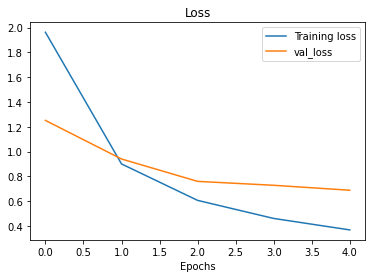

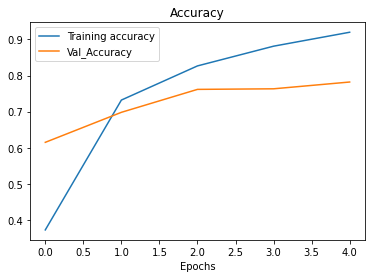

In [29]:
plot_loss_curves(history)

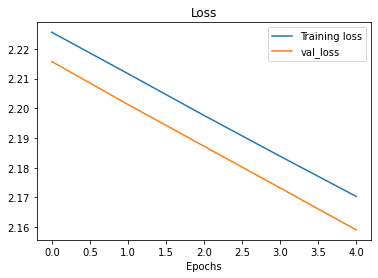

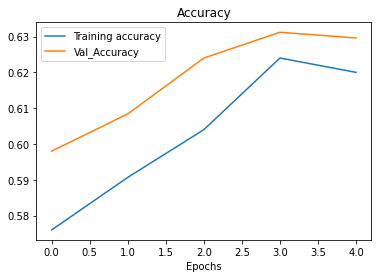

In [32]:
plot_loss_curves(hisoryE)

In [34]:
#How many layers does our effienctnet feature extractor have 

len(efficent_model.layers[0].weights)

311

In [35]:
len(resnet_model.layers[0].weights)

270

 #Differnt types of transfer learning 

 *"AS is TransferLearning" - using an exisitng model with no changes whatsoever (e.g using ImageNet model on 1000, ImageNet classes, 
                                                                                 none of your own)
 *"Feature Extraction" - transfer learning - use the prelearned patterns of an exisiting model (eg, efficentNetB0 trained on ImageNet) and adjust 
 the output layer for your own problems (1000 classes -> 10 classes of food)

 *"Fine Tuning Transfer layers" - Use the prelearned patterns of an exisitng model and fine-tune many or all of the underlying layers 
 (Including new output layers)

In [36]:
#Compairng our models results using TensorBoard

In [41]:
!tensorboard dev upload --logdir ./tensorflow_hub/ \
--name "EfficentNetB0 vs Resnet50v2" \
--description "Comparing two different TF Hub features extraction model architectures" \
--one_shot

2021-07-02 21:53:33.284323: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2

In [42]:
!tensorboard dev list

2021-07-02 21:58:32.758875: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
Data for the "text" plugin is now uploaded to TensorBoard.dev! Note that uploaded data is public. If you do not want to upload data for this plugin, use the "--plugins" command line argument.
https://tensorboard.dev/experiment/gVefrqQ1QRSmwEzmg4fgzA/
	Name                 EfficentNetB0 vs Resnet50v2
	Description          Comparing two different TF Hub features extraction model architectures
	Id                   gVefrqQ1QRSmwEzmg4fgzA
	Created              2021-07-02 21:54:06 (4 minutes ago)
	Updated              2021-07-02 21:54:11 (4 minutes ago)
	Runs                 8
	Tags                 5
	Scalars              150
	Tensor bytes         0
	Binary object bytes  13674730
Total: 1 experiment(s)
